In [1]:
from brian2 import *
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def calc_weight(M, alpha, mu, sigma):
    output = zeros((M,M))
    for i in np.arange(M):
        for j in np.arange(M):
            output[i,j] = exp(cos((2*pi*i/M) - (2*pi*j/M) - mu)/sigma**2)
    output = output * (alpha/np.max(output))
    output = 5.0 * fF * np.around(output/(5.0*fF))
    return output

In [3]:
def calc_weight_grid(M, alpha, mu, sigma):
    output = zeros((M))
    for i in np.arange(M):
        output[i] = exp(cos((2*pi*i/M) - mu)/sigma**2)
    output = output * (alpha/np.max(output))
    output = 5.0 * fF * np.around(output/(5.0*fF))
    return output

In [4]:
MODE = 'adaptive'
PARASITICS = True

In [5]:
# Define various equations

if MODE == 'adaptive':
    neuron_eq = '''
        dVm/dt = ((glm + gpar) / Cm) * (Vm_r - Vm)  : volt
        dVt/dt = ((glt + gpar) / Ct) * (Vt_r - Vt)  : volt
        
        # dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt
        # dVt/dt = (glt / Ct) * (Vt_r - Vt) : volt

        glm = flm * Cl                              : siemens
        glt = flt * Cl                              : siemens
        gpar = par_ctrl / par_leak_time * Cm : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
        Vt = Vt * (Vt > Vm) + Vt_r * (Vt <= Vm)
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
        Vt += (Cst/Ct) * (Vm_old - Vm_r)
    '''
else:
    neuron_eq = '''
        dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt

        glm = flm * Cl                    : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
    '''

# Synapse equation is the same for both modes!
syn_eq = '''
    Vsyn = (W/Cm)*(Em - Vm) : volt
    Em                      : volt
    W                       : farad
'''

In [6]:
# IFAT specific definitions
fF = 0.001 * pF
Vdd = 5 * volt
Cm = Ct = 440 * fF
Cl = 2 * fF

W_vals  = np.array([5, 10, 20, 40, 80]) * fF
Em_vals = np.array([0, 1/3, 2/3, 1]) * Vdd

par_ctrl = float(PARASITICS)
par_leak_time = 12.5 * ms

In [7]:
# Model parameters
Vm_r = 1 * volt
flm  = 0 * kHz
Csm  = W_vals[0]

Vt_r = 3.5 * volt
flt  = 0 * MHz
Cst  = 0 * fF

M = 64

In [8]:
# Connectivity specifics
alpha = sum(W_vals)
mu1 = 0
mu2 = 2*pi/3
mu3 = pi
sigma = 36 * pi/180

In [9]:
# Preferred direction for cell
theta1 = 0
theta2 = theta1 + 2*pi/3
theta3 = theta2 + 2*pi/3
lam = 10 # meters
d1 = lam * np.asarray([cos(theta1),sin(theta1)])
d2 = lam * np.asarray([cos(theta2),sin(theta2)])
d3 = lam * np.asarray([cos(theta3),sin(theta3)])

In [10]:
def timedrandwalk(v=5, dt=0.001*second, time=10*second, size=5):
    nsteps = int(time/dt)
    rwpath = np.zeros([nsteps,2])
    rwvel  = np.zeros([nsteps,2])
    vel = v*np.random.random()
    theta=math.pi*np.random.random()
    dx = vel*math.cos(theta)
    dy = vel*math.sin(theta)
    rwpath[1,:] = [dx, dy]
    rwvel[1,:] = [dx, dy]
    for step in np.arange(2,nsteps):
        if (step % 10*ms/dt):
            rwpath[step,:] = rwpath[step-1,:]
        else:
            while (np.abs(rwpath[step,:])>=(size/2.)).any():
                vel = v*np.random.random()
                theta=math.pi*np.random.random()
                dx = vel*math.cos(theta)
                dy = vel*math.sin(theta)
                rwpath[step,:] = rwpath[step-1,:] + [dx, dy]
                rwvel[step,:] = [dx, dy]
                
    return rwpath, rwvel

In [11]:
def timedrandwalk2(v=5, dt=1*ms, time=10*second, size=5):
    nsteps = int(time/dt)
    rwpath = np.zeros([nsteps,2]) * size/2.
    rwvel  = np.zeros([nsteps,2])
    for step in np.arange(1,nsteps):
            while (rwpath[step,:]>=(size)).any() or (rwpath[step,:]<=0).any():
                theta=2*math.pi*np.random.random()
                dx = v*math.cos(theta)
                dy = v*math.sin(theta)
                rwpath[step,:] = rwpath[step-1,:] + [dx, dy]
                rwvel[step,:] = [dx, dy]
    return rwpath, rwvel

In [12]:
def raster_path(size=1, time=10*second, dt=1*ms):
    speed = 0.02 # meters/second
    length = round(time/dt)
    ss = np.linspace(-size,size,sqrt(length))

    path = np.zeros([length, 2])
    for idx,y in enumerate(ss):
        path[idx*ss.size:(idx+1)*ss.size,0] = -ss if idx%2 else ss
        path[idx*ss.size:(idx+1)*ss.size,1] = y

    vel = np.zeros_like(path)
    vel[:-1] = path[1:]-path[:-1]
    
    return path, vel

In [13]:
path, vel = timedrandwalk2(v=0.01,dt=1*ms,time=10*second,size=0.5)

In [14]:
#path, vel = raster_path(0.1,30*second,1*ms)

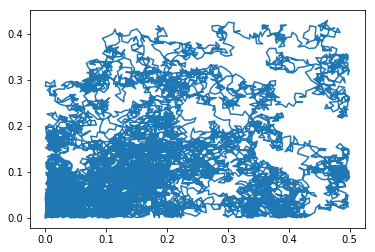

In [15]:
plot(path[:,0],path[:,1])

In [16]:
rundt = 20*ms
runtime = 20*second
path, vel = timedrandwalk2(v=0.005,dt=rundt,time=runtime,size=0.1)
#path, vel = raster_path(0.1, 30*second, 1*ms)

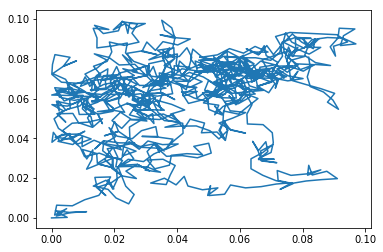

In [17]:
plot(path[:,0],path[:,1])

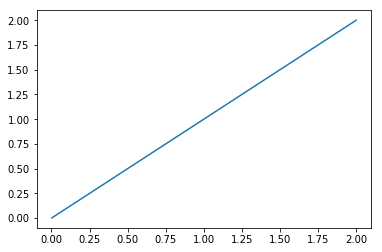

In [19]:
strt_vel = np.ones_like(vel) * 0.002

strt_path = cumsum(strt_vel, axis=0)

shape(strt_path)

plot(strt_path[:,0], strt_path[:,1])

veldot1 = TimedArray(np.dot(strt_vel,d1),dt=rundt)
veldot2 = TimedArray(np.dot(strt_vel,d2),dt=rundt)
veldot3 = TimedArray(np.dot(strt_vel,d3),dt=rundt)

In [ ]:
veldot1 = TimedArray(np.dot(vel,d1),dt=rundt)
veldot2 = TimedArray(np.dot(vel,d2),dt=rundt)
veldot3 = TimedArray(np.dot(vel,d3),dt=rundt)

In [85]:
start_scope()

G1 = NeuronGroup(2*M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
G1.Vt = Vt_r
G1.Vm = Vm_r
G1_exc = G1[:M]
G1_inh = G1[M:]

G1_e2i = Synapses(G1_exc, G1_inh, syn_eq, on_pre=presyn_eq)
G1_e2i.connect()
G1_e2i.Em = Em_vals[3]
G1_e2i.W = calc_weight(M,alpha,mu1,sigma).flatten()

G1_i2e = Synapses(G1_inh, G1_exc, syn_eq, on_pre=presyn_eq)
G1_i2e.connect()
G1_i2e.Em = Em_vals[0]
G1_i2e.W = calc_weight(M,alpha,mu2,sigma).flatten()

G1_i2i = Synapses(G1_inh, G1_inh, syn_eq, on_pre=presyn_eq)
G1_i2i.connect()
G1_i2i.Em = Em_vals[0]
G1_i2i.W = calc_weight(M,alpha,mu1,sigma).flatten()

P1_rates = '(3 + 20*veldot1(t))*kHz'
P1 = PoissonGroup(M,rates=P1_rates)
P1_syn = Synapses(P1, G1_exc, syn_eq, on_pre=presyn_eq)
P1_syn.connect('j==i')
P1_syn.Em = Em_vals[3]
P1_syn.W = W_vals[2] + W_vals[0]

G1e_sp = SpikeMonitor(G1_exc)
P1_rate = StateMonitor(P1, 'rates',record=True)

G2 = NeuronGroup(2*M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
G2.Vt = Vt_r
G2.Vm = Vm_r
G2_exc = G2[:M]
G2_inh = G2[M:]

G2_e2i = Synapses(G2_exc, G2_inh, syn_eq, on_pre=presyn_eq)
G2_e2i.connect()
G2_e2i.Em = Em_vals[3]
G2_e2i.W = calc_weight(M,alpha,mu1,sigma).flatten()

G2_i2e = Synapses(G2_inh, G2_exc, syn_eq, on_pre=presyn_eq)
G2_i2e.connect()
G2_i2e.Em = Em_vals[0]
G2_i2e.W = calc_weight(M,alpha,mu2,sigma).flatten()

G2_i2i = Synapses(G2_inh, G2_inh, syn_eq, on_pre=presyn_eq)
G2_i2i.connect()
G2_i2i.Em = Em_vals[0]
G2_i2i.W = calc_weight(M,alpha,mu1,sigma).flatten()

P2_rates = '(3 + 20*veldot2(t))*kHz'
P2 = PoissonGroup(M,rates=P2_rates)
P2_syn = Synapses(P2, G2_exc, syn_eq, on_pre=presyn_eq)
P2_syn.connect('j==i')
P2_syn.Em = Em_vals[3]
P2_syn.W = W_vals[2] + W_vals[0]

G2e_sp = SpikeMonitor(G2_exc)
P2_rate = StateMonitor(P2, 'rates',record=True)

G3 = NeuronGroup(2*M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
G3.Vt = Vt_r
G3.Vm = Vm_r
G3_exc = G3[:M]
G3_inh = G3[M:]

G3_e2i = Synapses(G3_exc, G3_inh, syn_eq, on_pre=presyn_eq)
G3_e2i.connect()
G3_e2i.Em = Em_vals[3]
G3_e2i.W = calc_weight(M,alpha,mu1,sigma).flatten()

G3_i2e = Synapses(G3_inh, G3_exc, syn_eq, on_pre=presyn_eq)
G3_i2e.connect()
G3_i2e.Em = Em_vals[0]
G3_i2e.W = calc_weight(M,alpha,mu2,sigma).flatten()

G3_i2i = Synapses(G3_inh, G3_inh, syn_eq, on_pre=presyn_eq)
G3_i2i.connect()
G3_i2i.Em = Em_vals[0]
G3_i2i.W = calc_weight(M,alpha,mu1,sigma).flatten()

P3_rates = '(3 + 20*veldot3(t))*kHz'
P3 = PoissonGroup(M,rates=P3_rates)
P3_syn = Synapses(P3, G3_exc, syn_eq, on_pre=presyn_eq)
P3_syn.connect('j==i')
P3_syn.Em = Em_vals[3]
P3_syn.W = W_vals[2] + W_vals[0]

G3e_sp = SpikeMonitor(G3_exc)
P3_rate = StateMonitor(P3, 'rates',record=True)

GRID = NeuronGroup(3, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
GRID.Vt = Vt_r
GRID.Vm = Vm_r
GRID0 = GRID[:1]
GRID1 = GRID[1:2]
GRID2 = GRID[2:]

G1_GRID0 = Synapses(G1_exc, GRID0, syn_eq, on_pre=presyn_eq)
G1_GRID0.connect()
G1_GRID0.Em = Em_vals[3]
G1_GRID0.W = calc_weight_grid(M, alpha/3, 0, 1*sigma)

G2_GRID0 = Synapses(G2_inh, GRID0, syn_eq, on_pre=presyn_eq)
G2_GRID0.connect()
G2_GRID0.Em = Em_vals[0]
G2_GRID0.W = calc_weight_grid(M, alpha/1, pi, 1*sigma)

G3_GRID0 = Synapses(G3_exc, GRID0, syn_eq, on_pre=presyn_eq)
G3_GRID0.connect()
G3_GRID0.Em = Em_vals[3]
G3_GRID0.W = calc_weight_grid(M, alpha/3, 0, 1*sigma)

GRID_sp = SpikeMonitor(GRID)
GRID_v = StateMonitor(GRID, 'Vm', record=True)
GRID0_rate = PopulationRateMonitor(GRID0)

store()

In [86]:
restore()
BrianLogger.suppress_hierarchy('brian2.codegen.generators.base')
run(runtime,report='text')

Starting simulation at t=0. s for a duration of 20. s
3.8191 (19%) simulated in 10s, estimated 42s remaining.
7.6498 (38%) simulated in 20s, estimated 32s remaining.
11.4708 (57%) simulated in 30s, estimated 22s remaining.
15.2796 (76%) simulated in 40s, estimated 12s remaining.
19.1182 (95%) simulated in 50s, estimated 2s remaining.
20.0 (100%) simulated in 52s


(4, 5)

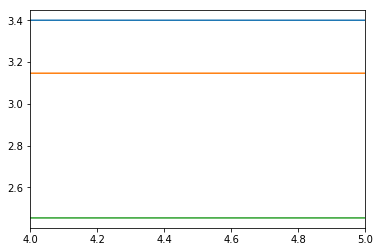

In [87]:
plot(P1_rate.t/second, P1_rate.rates[0]/kHz,
     P2_rate.t/second, P2_rate.rates[0]/kHz,
     P3_rate.t/second, P3_rate.rates[0]/kHz)
xlim([4,5])

(3, 4.5)

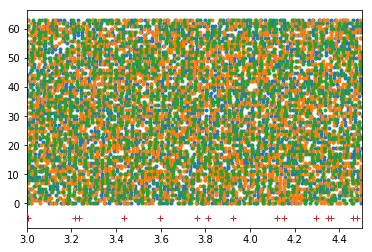

In [88]:
plot(G1e_sp.t/second, G1e_sp.i,'.C0',
     G2e_sp.t/second, G2e_sp.i,'.C1',
     G3e_sp.t/second, G3e_sp.i,'.C2',
     GRID_sp.t/second, GRID_sp.i-5,'+C3')
#xlim([33.2,33.4])
xlim([3,4.5])

(4, 5)

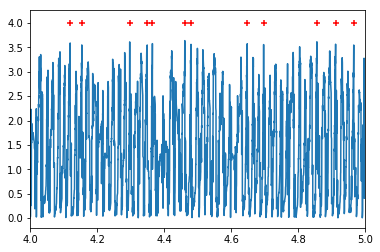

In [89]:
plot(GRID_v.t/second, GRID_v.Vm[0]/volt)
scatter(GRID_sp.t[GRID_sp.i==0]/second,4*ones(len(GRID_sp.t[GRID_sp.i==0])),marker='+',color='r')
xlim([4,5])

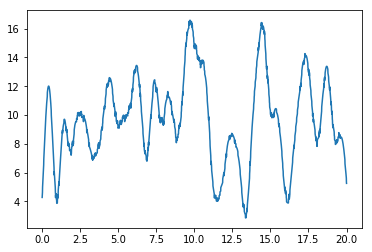

In [90]:
plot(GRID0_rate.t/second, GRID0_rate.smooth_rate(width=250*ms))

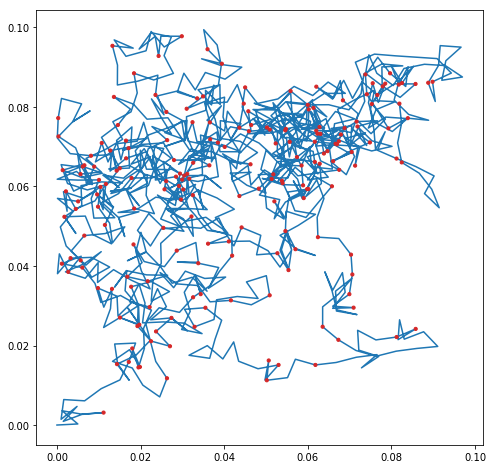

In [91]:
times = np.zeros_like(path[:,0])
times[np.array(GRID_sp.t/(rundt),dtype=int)] = 1

figure(figsize=(8,8))
plot(path[:,0],path[:,1], zorder=1);
scatter(path[:,0],path[:,1], s=times*10, color='C3', zorder=2)

# Rerun the following using newly generated Poisson inputs each time

In [103]:
shape(GRID_sp.i)

(195,)

In [105]:
spike_times = []
nruns = 10
avg_rates   = np.zeros((200000,nruns))
for idx in range(nruns):
    restore()
    print('Run {}/{}...'.format(idx+1,nruns))
    run(runtime, report='text')
    spike_times.append(GRID_sp)
    avg_rates[:,idx] = GRID0_rate.smooth_rate(width=100*ms)

Run 1/10...
Starting simulation at t=0. s for a duration of 20. s
3.8503000000000003 (19%) simulated in 10s, estimated 42s remaining.
7.7072 (38%) simulated in 20s, estimated 32s remaining.
11.567400000000001 (57%) simulated in 30s, estimated 22s remaining.
15.4192 (77%) simulated in 40s, estimated 12s remaining.
19.2864 (96%) simulated in 50s, estimated 2s remaining.
20.0 (100%) simulated in 51s
Run 2/10...
Starting simulation at t=0. s for a duration of 20. s
3.8475 (19%) simulated in 10s, estimated 42s remaining.
7.7217 (38%) simulated in 20s, estimated 32s remaining.
11.5782 (57%) simulated in 30s, estimated 22s remaining.
15.4303 (77%) simulated in 40s, estimated 12s remaining.
19.28 (96%) simulated in 50s, estimated 2s remaining.
20.0 (100%) simulated in 51s
Run 3/10...
Starting simulation at t=0. s for a duration of 20. s
3.8924000000000003 (19%) simulated in 10s, estimated 41s remaining.
7.7415 (38%) simulated in 20s, estimated 32s remaining.
11.55 (57%) simulated in 30s, estim

In [106]:
meanrate = mean(avg_rates,axis=1)

(0, 4)

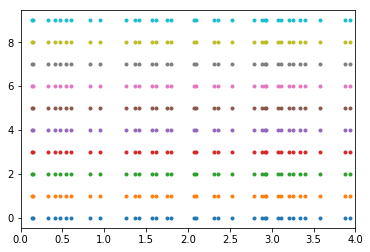

In [114]:
for i in range(10):
    plot(spike_times[i].t/second,i+spike_times[i].i,'.')
xlim([0,4])

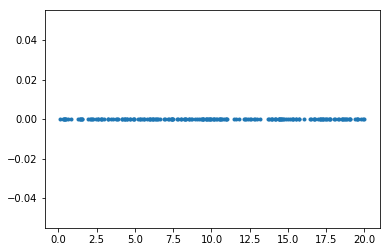

In [92]:
plot(GRID_sp.t/second, GRID_sp.i,'.')

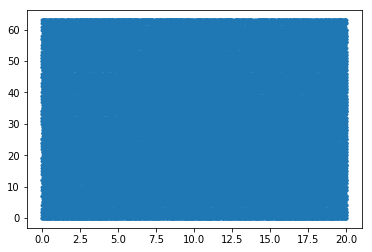

In [93]:
plot(G1e_sp.t/second, G1e_sp.i,'.')
#xlim([20,20.3])

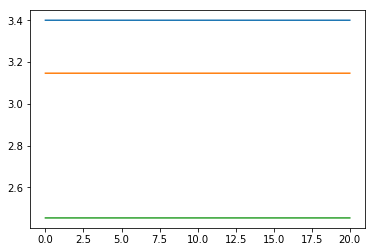

In [94]:
plot(P1_rate.t/second, P1_rate.rates[0]/kHz,
     P2_rate.t/second, P2_rate.rates[0]/kHz,
     P3_rate.t/second, P3_rate.rates[0]/kHz)

(4, 5.5)

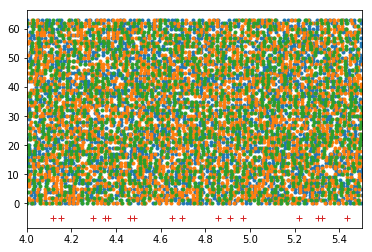

In [95]:
plot(G1e_sp.t/second, G1e_sp.i,'.C0',
     G2e_sp.t/second, G2e_sp.i,'.C1',
     G3e_sp.t/second, G3e_sp.i,'.C2',
     GRID_sp.t/second, GRID_sp.i-5,'+C3')
#xlim([33.2,33.4])
xlim([4,5.5])

(1, 10)

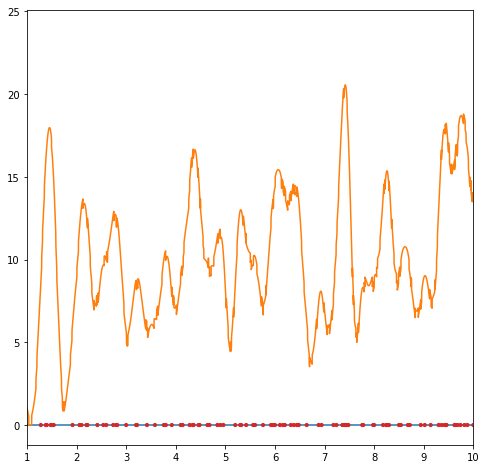

In [101]:
times = np.zeros_like(strt_path[:,0])
times[np.array(GRID_sp.t/(rundt),dtype=int)] = 1
time = np.arange(0,runtime,rundt)
figure(figsize=(8,8))
plot(time,zeros_like(strt_path[:,0]), zorder=1);
scatter(time,zeros_like(strt_path[:,0]), s=times*10, color='C3', zorder=2)
#plot(time,cumsum(times)/mean(times))
plot(GRID0_rate.t/second, GRID0_rate.smooth_rate(width=100*ms))
xlim([1,10])
#ylim([-1,1])

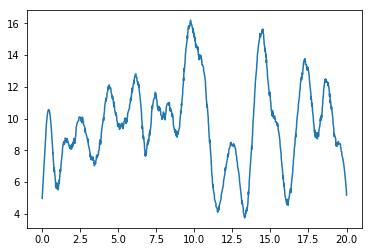

In [97]:
plot(GRID0_rate.t/second, GRID0_rate.smooth_rate(width=300*ms))
#xlim([40,50])